In [2]:
import numpy as np
import IPython
from IPython.display import Audio
import torch
import torch.nn as nn
import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
# from data import AudioData, get_dataloaders
from data import AudioData, get_dataloaders

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def display(data, fs=16000):
    IPython.display.display(Audio(data, rate=fs))

In [6]:
ad = AudioData(n_mfcc = 40, fs=16000)

In [7]:
train_dataloader, test_dataloader = get_dataloaders(ad)

In [8]:
print(ad.sampling_frequency)

16000


In [34]:
for e in train_dataloader:
    X,y = e
    print('decoding x')
    decoded_X = ad.decode(X)
    print('decoded, displaying...')
    display(decoded_X)
    print('displayed')
    print(X.shape)
    print(y.shape)
    print('decoding y')
    decoded_y = ad.decode(y)
    print('decoded, dispalying')
    display(decoded_y)
    print('displayyed')
    break

decoding x
decoded, displaying...


displayed
torch.Size([1, 525, 40])
torch.Size([1, 525, 40])
decoding y
decoded, dispalying


displayyed


In [35]:
class IDK(nn.Module):
    def __init__(self, n_mfcc=40):
        super(IDK, self).__init__()
        self.l1 = torch.nn.Linear(n_mfcc, 128)
        self.l2 = torch.nn.Linear(128, n_mfcc)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [8]:
linear = IDK(n_mfcc=40).to(device)

In [101]:
class CNN(nn.Module):
    def __init__(self, n_mfcc=40):
        super(CNN, self).__init__()
        self.n_mfcc=n_mfcc
        self.k_size = 10
        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 32, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 16, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 4, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 2, kernel_size=self.k_size, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(2, 1, kernel_size=self.k_size, padding='same'),
        )
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(self.n_mfcc, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_mfcc)
        )
    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.squeeze(x)
        x = self.linear_layers(x)
        return x

In [102]:
cnn = CNN(n_mfcc = 80).to(device)
print(cnn)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(64, 32, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): Conv2d(32, 16, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(16, 8, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): Conv2d(8, 4, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (15): ReLU()
    (16): Conv2d(4, 2, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (17): ReLU()
    (18): Conv2d(2, 1, kernel_size=(10, 10), stride=(1, 1), padding=same)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=80, out_fea

In [107]:
loss = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters())

EPOCHS = 1

losses = []
validation_loss = []

for i in range(EPOCHS):
    for batch in tqdm.tqdm(train_dataloader):
        cnn.zero_grad()
        batchX, batchY = batch
        batchX = torch.unsqueeze(batchX, 0) # 1 x 1 x n x 40
        batchY = torch.squeeze(batchY) # n x 40

        batchX = batchX.type(torch.FloatTensor)
        batchY = batchY.type(torch.FloatTensor)

        batchX = batchX.to(device)
        batchY = batchY.to(device)
        
        out = cnn(batchX)
        l = loss(out, batchY)
        l.backward()
        losses.append(l)
        optimizer.step()

#     with torch.no_grad():
# #         out = cnn(valX)
#         out = linear(valX)
#         L = loss(out, valY)
# #         cnn_validation_loss.append(float(L))
#         linear_validation_loss.append(float(L))
# torch.save(cnn.state_dict(), 'model')

100%|██████████| 906/906 [07:32<00:00,  2.00it/s]


In [67]:
torch.save(cnn.state_dict(), 'modelCNNLinear')

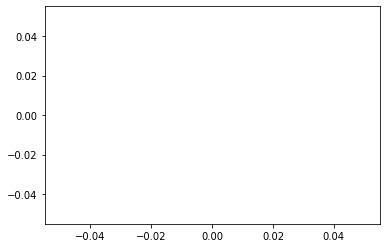

In [99]:
plt.plot(losses[400:])

In [70]:
print(cnn)

CNN(
  (pre_stuff): Sequential(
    (0): Linear(in_features=80, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=80, bias=True)
  )
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(128, 64, kernel_size=(10, 10), stride=(1, 1), padding=same)
    (13): ReLU()


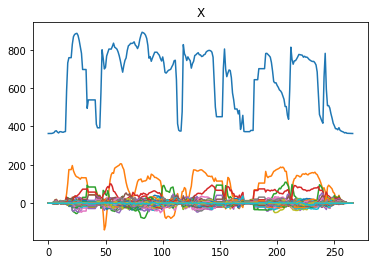

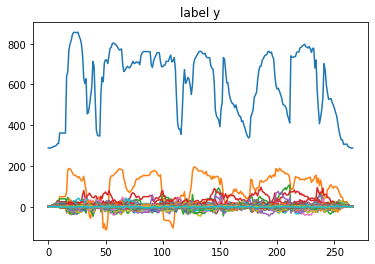

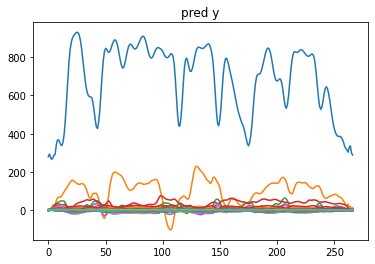

In [108]:
for validation in train_dataloader:
    valX, valY = validation
    plt.figure(1)
    plt.title('X')
    plt.plot(torch.squeeze(valX))
    plt.figure(2)
    plt.title('label y')
    plt.plot(torch.squeeze(valY))
    
    valX = valX.type(torch.FloatTensor)
    valY = valY.type(torch.FloatTensor)
#     decoded = ad.decode(torch.squeeze(valX, 1).detach().numpy())
#     print('x')
#     display(decoded)
#     print('label y')
#     decoded = ad.decode(torch.squeeze(valY, 1).detach().numpy())
#     display(decoded)

    valX = torch.unsqueeze(valX, 0).to(device)
    valY = torch.unsqueeze(valY, 0).to(device)
    
    out = cnn(valX).cpu()
#     decoded = ad.decode(torch.unsqueeze(out, 0).detach().numpy())
#     print('pred y')
#     display(decoded)
    
    
    out1 = out.detach().numpy()
    
    plt.figure(3)
    plt.title('pred y')
    plt.plot(out1)
    break

In [116]:
out[:, 0] = torch.squeeze(valX)[:, 0]
decoded = ad.decode(torch.unsqueeze(out, 0).detach().numpy())

In [117]:
display(decoded)

In [48]:
torch.save(cnn.state_dict(), 'model')

In [111]:
print(out.shape)
print(valX.shape)

torch.Size([267, 80])
torch.Size([1, 1, 267, 80])


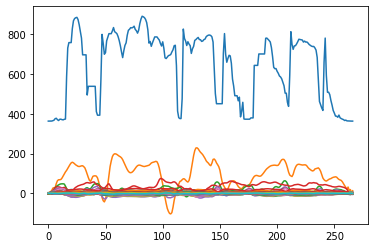

In [115]:
plt.plot(out.detach().numpy())
pass